### This notebook contains the final interpretation for the Correlation Study

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
from typing import Tuple, List, Dict, Optional
import re
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 100)

### Functions

In [32]:
def calc_bowley_skew(df_col: pd.Series) -> Tuple[float, float]:
    """
    Calculate Bowley's coefficient of skewness for a pandas DataFrame column.

    Args:
        df_col (pandas.Series): A pandas DataFrame column.

    Returns:
        float: Bowley's coefficient of skewness.

    Example usage:
        data = {'percent_human': [10, 20, 30, 40, 50, 60, 70]}
        df = pd.DataFrame(data)

        bowley_skew = calc_bowley_skew(df['percent_human'])
        print(bowley_skew)
    """

    if not np.issubdtype(df_col.dtype, np.number):
        raise TypeError("Input column must contain numeric data.")
    
    if df_col.isnull().values.any():
        raise ValueError("Input column contains missing values.")

    q1 = df_col.quantile(0.25)
    q2 = df_col.quantile(0.5)
    q3 = df_col.quantile(0.75)

    bowley_skewness = round((((q3 - q2) - (q2 - q1))) / (q3 - q1), 2)

    return bowley_skewness

In [33]:
# depricated
def multiplotv_dark_f_old(df: pd.DataFrame, fig_name: str = '', filter_col: str = None, fmin: float = None, fmax: float = None, dark_mode: bool = False) -> None:
    """
    Generate a set of 4 plots to visualize the relationship between two variables in a DataFrame.
    :param df: DataFrame containing the data
    :param filter_col: Name of the column to filter on (optional)
    :param filter_min: Minimum value for the filter_col (optional)
    :param filter_max: Maximum value for the filter_col (optional)
    """

    if fig_name == '':
        fig_name = 'Figure X'
    
    # colors for dark mode and light mode 
    if dark_mode:
        face_color = '0.1'
        color1 = 'white'
        #color2 = '#bbbbbb'
        color2 = 'green'
        #color2 = '#0000fc'
    else:
        face_color = '.9'
        color1 = 'black'
        #color2 = 'green'
        color2 = '#0000fc'

    # define subplots
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16, 12), facecolor=face_color)
    
    # Set background color to black
    #plt.style.use('dark_background')

    # apply filter and subtitle
    if filter_col:
        if fmin is not None and fmax is not None:
            if fmin < fmax:
                fig.text(0.5, 0.94, f'Filtered on {fmin} < {filter_col} < {fmax}', ha='center', fontsize=16, color=color1)
                df = df[(df[filter_col] <= fmax) & (df[filter_col] >= fmin)]
            else:
                fmin, fmax = fmax, fmin
                fig.text(0.5, 0.94, f'Filtered on {fmin} > {filter_col} > {fmax}', ha='center', fontsize=16, color=color1)
                df = df[(df[filter_col] >= fmax) | (df[filter_col] <= fmin)]
        elif fmin is not None and fmax is None:
            fig.text(0.5, 0.94, f'Filtered on {filter_col} > {fmin}', ha='center', fontsize=16, color=color1)
            df = df[df[filter_col] >= fmin]
        elif fmin is None and fmax is not None:
            fig.text(0.5, 0.94, f'Filtered on {filter_col} < {fmax}', ha='center', fontsize=16, color=color1)
            df = df[df[filter_col] <= fmax]
        else:
            print(f'Warning: you must provide a min and/or max on which to filter on {filter_col} or no filtering will occur')

    # apply main title
    main_title = f'{fig_name}: Data Distribution and Correlation of Rank vs Percent Human ({len(df)} data points)'
    fig.suptitle(main_title, fontsize=20, fontweight='bold', y=.98, color=color1)
    
    
    # SubFig a: Q-Q plot [0, 0]
    st.probplot(df['percent_human'], dist='norm', plot=axs[0, 0])
    axs[0, 0].set_title(f'{fig_name}a: Q-Q Plot of Percent Human')
    axs[0, 0].set_xlabel('Theoretical Quantiles')
    axs[0, 0].set_ylabel('Sample Quantiles')
    axs[0, 0].text(0.03, 0.96, 'Data is not normally distributed.', transform=axs[0, 0].transAxes, fontsize=12, verticalalignment='top', color=color1)
    axs[0, 0].lines[0].set_color(color2)

    
    # SubFig b: Histogram [0, 1]
    sns.histplot(data=df['percent_human'], kde=False, binwidth=1, color=color2, ax=axs[0, 1], edgecolor='grey')
    axs[0, 1].set_title(f'{fig_name}b: Histogram of Percent Human')
    axs[0, 1].set_xlabel('Percent Human')
    axs[0, 1].set_ylabel('Count')
    axs[0, 1].set_xlim(-5, 105)
    axs[0, 1].set_ylim(0, None)
    #skewness = round(st.skew(df['percent_human']), 2) # this is Pearsons skewness
    bowley_skew = calc_bowley_skew(df['percent_human'])
    axs[0, 1].text(0.03, 0.96, f'Bowley Skewness: {bowley_skew}', transform=axs[0, 1].transAxes, fontsize=12, verticalalignment='top', color=color1)
    #axs[0, 1].text(0.02, 0.90, f'Over 1/3 of data in top 2%', transform=axs[0, 1].transAxes, fontsize=12, verticalalignment='top', color='black')

    
    # SubFig c: Violin plot [1, 0]
    sns.violinplot(ax=axs[1, 0], data=df, x="rank", y="percent_human", scale="count", inner="box", color=color2, saturation=.8, cut=0, linewidth=.9)

        # plot mean lines
    for i, mean in enumerate(df.groupby("rank")["percent_human"].mean()):
        axs[1, 0].hlines(mean, i-0.25, i+0.25, linewidth=1, color=color2, zorder=100)

        # plot median markers
    median_markers = df.groupby('rank')['percent_human'].median()
    sns.scatterplot(ax=axs[1, 0], x=median_markers.index-1, y=median_markers.values, marker='o', s=20, color=color1, edgecolor='black', zorder=100)
    
    axs[1, 0].set_title(f'{fig_name}c: Percent Human vs Rank')
    axs[1, 0].set_xlabel('Rank')
    axs[1, 0].set_ylabel('Percent Human')

   
    # SubFig d: Scatter plot [1, 1]
    grouped_data = df.groupby('rank')
    mean_percent_human = grouped_data['percent_human'].mean().reset_index()
    sns.scatterplot(ax=axs[1, 1], data=mean_percent_human, x='rank', y='percent_human',  color=color2, edgecolor=None)
    sns.regplot(ax=axs[1, 1], data=mean_percent_human, x='rank', y='percent_human', color=color2, scatter=False, line_kws={'linestyle':'--'})
    axs[1, 1].set_title(f'{fig_name}d: Mean Percent Human vs Rank')
    axs[1, 1].set_xlabel('Rank')
    axs[1, 1].set_ylabel('Mean Percent Human')
    axs[1, 1].set_xticks(np.arange(1, 21))
    mean = round(df['percent_human'].mean(),0)
    if mean % 2:
        mean = mean - 1
    y_max = mean + 5
    y_min = mean - 4
    axs[1, 1].set_yticks(np.arange(mean-6, mean+6))
    axs[1, 1].legend(handles=axs[1, 1].lines[::len(mean_percent_human)], labels=['Best fit line'], facecolor=face_color, labelcolor=color1)
    axs[1, 1].set_ylim(y_min-0.6, y_max+0.5)
    #axs[1, 1].text(0.02, 0.05, f'Percent Human is weakly correlated to Rank with a high degree of certainty', transform=axs[1, 1].transAxes, fontsize=10, verticalalignment='top', color=color1)

        # Calculate correlation coefficients and p-values
    pb_corr, pb_pval = st.pointbiserialr(df['rank'], df['percent_human'])
    spearman_corr, spearman_pval = st.spearmanr(df['rank'], df['percent_human'])
    kendall_tau, kendall_pval = st.kendalltau(df['rank'], df['percent_human'])

        # Create a dictionary to store the results
    corr = {
        'Method': ['Point Biserial', 'Spearman', 'Kendall'],
        'Corr Coef': [pb_corr, spearman_corr, kendall_tau],
        'P-value': [pb_pval, spearman_pval, kendall_pval]
    }

        # Create a pandas dataframe from the corr dict
    df_corr = pd.DataFrame(corr)

        # Create a table to display the correlation coefficients and p-values
    table_data = [list(df_corr.columns)] + df_corr.values.tolist()
    table = axs[1, 1].table(cellText=table_data,
                    colLabels=None,
                    cellLoc='center',
                    bbox=[0.02, 0.03, 0.5, 0.15],  # x, y, width, height
                    cellColours=[[face_color]*3] + [[face_color]*3]*len(df_corr))
    table.set_fontsize(10)
    for cell in table.get_celld().values():
        cell.set_linewidth(0)
        cell.set_edgecolor('none')
        cell.set_text_props(color=color1)

        # Format the table to use 4 significant figures
    for i in range(1, len(table_data)):
        for j in range(1, 3):
            cell = table.get_celld()[i, j]
            cell_text = cell.get_text().get_text()
            cell_text = float(cell_text)
            cell_text = f'{cell_text:.3g}'
            cell.get_text().set_text(cell_text)
            #cell.set_edgecolor('white')
    
    for ax in axs.flat:
        ax.tick_params(axis='x', labelsize=12, colors=color1)
        ax.tick_params(axis='y', labelsize=12, colors=color1)
        ax.set_xlabel(ax.get_xlabel(), fontdict={'fontsize': 14, 'color': color1})
        ax.set_ylabel(ax.get_ylabel(), fontdict={'fontsize': 14, 'color': color1})
        ax.set_title(ax.get_title(), fontdict={'fontsize': 16, 'color': color1})
        ax.set_facecolor(face_color)
        for spine in ax.spines.values():
            spine.set_edgecolor(color1)
            #spine.set_linewidth(2)
    
    # shrink outer margin
    fig.subplots_adjust(left=0.05, right=0.95, top=.90, bottom=0.05)
    

    pattern = re.compile(r'\s+')
    fig_name = pattern.sub('_', fig_name)
    file_name = 'figures/' + fig_name + '_a-d.png'
    fig.savefig(file_name)

    plt.show()

In [34]:
def multiplotv_dark_f(df: pd.DataFrame, fig_name: str = '', filter_col: str = None, fmin: float = None, fmax: float = None, dark_mode: bool = False) -> None:
    """
    Generate a set of 4 plots to visualize the relationship between two variables in a DataFrame.
    :param df: DataFrame containing the data
    :param filter_col: Name of the column to filter on (optional)
    :param filter_min: Minimum value for the filter_col (optional)
    :param filter_max: Maximum value for the filter_col (optional)
    """

    if fig_name == '':
        fig_name = 'Figure X'
    
    # colors for dark mode and light mode 
    if dark_mode:
        face_color = '0.1'
        color1 = 'white'
        #color2 = '#bbbbbb'
        color2 = 'green'
        #color2 = '#0000fc'
        color3 = '#FF5757' #Originality.AI orange
    else:
        face_color = '.9'
        #color1 = 'black'
        color1 = '#051D40' # Originality.AI dark blue
        #color2 = 'green'
        #color2 = '#0000fc' # blue
        color2 = '#55aeff' # Originality.AI light blue
        color3 = '#FF5757' #Originality.AI orange
        

    # define subplots
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16, 12), facecolor=face_color)
    
    # Set background color to black
    #plt.style.use('dark_background')

    # apply filter and subtitle
    if filter_col:
        if fmin is not None and fmax is not None:
            if fmin < fmax:
                fig.text(0.5, 0.94, f'Filtered on {fmin} < {filter_col} < {fmax}', ha='center', fontsize=16, color=color1)
                df = df[(df[filter_col] <= fmax) & (df[filter_col] >= fmin)]
            else:
                fmin, fmax = fmax, fmin
                fig.text(0.5, 0.94, f'Filtered on {fmin} > {filter_col} > {fmax}', ha='center', fontsize=16, color=color1)
                df = df[(df[filter_col] >= fmax) | (df[filter_col] <= fmin)]
        elif fmin is not None and fmax is None:
            fig.text(0.5, 0.94, f'Filtered on {filter_col} > {fmin}', ha='center', fontsize=16, color=color1)
            df = df[df[filter_col] >= fmin]
        elif fmin is None and fmax is not None:
            fig.text(0.5, 0.94, f'Filtered on {filter_col} < {fmax}', ha='center', fontsize=16, color=color1)
            df = df[df[filter_col] <= fmax]
        else:
            print(f'Warning: you must provide a min and/or max on which to filter on {filter_col} or no filtering will occur')

    # apply main title
    main_title = f'{fig_name}: Data Distribution and Correlation of Rank vs Percent Human ({len(df)} data points)'
    fig.suptitle(main_title, fontsize=20, fontweight='bold', y=.98, color=color1)
    
    
    # SubFig a: Q-Q plot [0, 0] # old plot
    # st.probplot(df['percent_human'], dist='norm', plot=axs[0, 0])
    # axs[0, 0].set_title(f'{fig_name}a: Q-Q Plot of Percent Human')
    # axs[0, 0].set_xlabel('Theoretical Quantiles')
    # axs[0, 0].set_ylabel('Sample Quantiles')
    # axs[0, 0].text(0.03, 0.96, 'Data is not normally distributed.', transform=axs[0, 0].transAxes, fontsize=12, verticalalignment='top', color=color1)
    # axs[0, 0].lines[0].set_color(color2)


    # SubFig a: Q-Q plot [0, 0]
    osm, osr = st.probplot(df['percent_human'], dist='norm', fit=False)
    sorted_percent_human = np.sort(df['percent_human'])
    axs[0, 0].scatter(osm, sorted_percent_human, color=color2)

        # Add the reference line with red color
    slope, intercept, _, _, _ = st.linregress(osm, sorted_percent_human)
    x_values = np.array(axs[0, 0].get_xlim())
    y_values = intercept + slope * x_values
    axs[0, 0].plot(x_values, y_values, color=color3)

        # Set the titles and labels
    axs[0, 0].set_title(f'{fig_name}a: Q-Q Plot of Percent Human')
    axs[0, 0].set_xlabel('Theoretical Quantiles')
    axs[0, 0].set_ylabel('Sample Quantiles')
    axs[0, 0].text(0.03, 0.96, 'Data is not normally distributed.', transform=axs[0, 0].transAxes, fontsize=12, verticalalignment='top', color=color1)

    
    # SubFig b: Histogram [0, 1]
    sns.histplot(data=df['percent_human'], kde=False, binwidth=1, color=color2, ax=axs[0, 1], edgecolor=color1)
    axs[0, 1].set_title(f'{fig_name}b: Histogram of Percent Human')
    axs[0, 1].set_xlabel('Percent Human')
    axs[0, 1].set_ylabel('Count')
    axs[0, 1].set_xlim(-5, 105)
    axs[0, 1].set_ylim(0, None)
    bowley_skew = calc_bowley_skew(df['percent_human'])
    axs[0, 1].text(0.03, 0.96, f'Bowley Skewness: {bowley_skew}', transform=axs[0, 1].transAxes, fontsize=12, verticalalignment='top', color=color1)
    #axs[0, 1].text(0.02, 0.90, f'Over 1/3 of data in top 2%', transform=axs[0, 1].transAxes, fontsize=12, verticalalignment='top', color='black')


    # SubFig c: Violin plot [1, 0]
    grouped_data = df.groupby("rank")["percent_human"].apply(list)

        # Create custom violin plots using sns.violinplot
    custom_palette = {i: color2 for i in range(1, len(df['rank'].unique()) + 1)}
    sns.violinplot(ax=axs[1, 0], data=df, x="rank", y="percent_human", scale="count", inner=None, palette=custom_palette, cut=0, linewidth=.9)

        # Set edge color for violin plots
    for violin in axs[1, 0].collections:
        violin.set_edgecolor(color1)

        # Custom box plots
    for rank, values in grouped_data.items():
        box = axs[1, 0].boxplot(values, positions=[rank - 1], widths=0.1, patch_artist=True, sym='')
        for patch in box['boxes']:
            patch.set_facecolor(color1)
            patch.set_edgecolor(color1)

        # Plot median markers
    median_markers = df.groupby('rank')['percent_human'].median()
    sns.scatterplot(ax=axs[1, 0], x=median_markers.index-1, y=median_markers.values, marker='o', s=20, color=color3, edgecolor=color1, zorder=100)

        # Plot mean lines
    for i, mean in enumerate(df.groupby("rank")["percent_human"].mean()):
        axs[1, 0].hlines(mean, i-0.25, i+0.25, linewidth=1, color=color1, zorder=100)

    axs[1, 0].set_title(f'{fig_name}c: Percent Human vs Rank')
    axs[1, 0].set_xlabel('Rank')
    axs[1, 0].set_ylabel('Percent Human')


    # SubFig d: Scatter plot [1, 1]
    grouped_data = df.groupby('rank')
    mean_percent_human = grouped_data['percent_human'].mean().reset_index()
    
    reg2 = sns.regplot(ax=axs[1, 1], data=mean_percent_human, x='rank', y='percent_human', color=color3, scatter=False, line_kws={'linestyle':'--'}, ci=None, label='Best fit line')
    sns.scatterplot(ax=axs[1, 1], data=mean_percent_human, x='rank', y='percent_human',  color=color2, edgecolor=color1, zorder=10)
    sns.regplot(ax=axs[1, 1], data=mean_percent_human, x='rank', y='percent_human', color=color2, scatter=False, line_kws={'linestyle':''})

    axs[1, 1].set_title(f'{fig_name}d: Mean Percent Human vs Rank')
    axs[1, 1].set_xlabel('Rank')
    axs[1, 1].set_ylabel('Mean Percent Human')
    axs[1, 1].set_xticks(np.arange(1, 21))
    handles, labels = reg2.get_legend_handles_labels()
    legend = axs[1, 1].legend(handles=handles, labels=labels, facecolor=face_color, labelcolor=color1)
    legend.get_frame().set_edgecolor(color1)

    pb_corr, pb_pval = st.pointbiserialr(df['rank'], df['percent_human'])
    axs[1, 1].text(0.02, 0.05, f"Point Biseral correlation coeficent: {pb_corr:.3g}, p-value: {pb_pval:.3g}", transform=axs[1, 1].transAxes, fontsize=12, verticalalignment='top', color=color1)
    #axs[1, 1].text(0.02, 0.05, f'Percent Human is weakly correlated to Rank with a high degree of certainty', transform=axs[1, 1].transAxes, fontsize=10, verticalalignment='top', color=color1)

        # add slope to inset text
    slope, _, _, _, _ = st.linregress(df['rank'], df['percent_human'])
    axs[1, 1].text(0.02, 0.10, f'Slope: {slope:.3f}% /  rank', transform=axs[1, 1].transAxes, fontsize=12, verticalalignment='top', color=color1)
    #axs[1, 1].text(0.02, 0.05, f'Percent Human is weakly correlated to Rank with a high degree of certainty', transform=axs[1, 1].transAxes, fontsize=10, verticalalignment='top', color=color1)

        # set y scale the same for each plot
    # mean = round(df['percent_human'].mean(),0)
    # if mean % 2:
    #     mean = mean - 1
    # y_max = mean + 5
    # y_min = mean - 4
    #axs[1, 1].set_yticks(np.arange(mean-6, mean+6))
    #axs[1, 1].set_ylim(y_min-0.6, y_max+0.5)
    

        # Calculate correlation coefficients and p-values
    #pb_corr, pb_pval = st.pointbiserialr(df['rank'], df['percent_human'])
    #spearman_corr, spearman_pval = st.spearmanr(df['rank'], df['percent_human'])
    #kendall_tau, kendall_pval = st.kendalltau(df['rank'], df['percent_human'])

        # Create a dictionary to store the results for table with 3 methods
    # corr = {
    #     'Method': ['Point Biserial', 'Spearman', 'Kendall'],
    #     'Corr Coef': [pb_corr, spearman_corr, kendall_tau],
    #     'P-value': [pb_pval, spearman_pval, kendall_pval]
    # }

    #     # Create a dictionary to store the results for table for point biseral
    # corr = {
    #     'Method': ['Point Biserial'],
    #     'Corr Coef': [pb_corr],
    #     'P-value': [pb_pval]
    # }

    #     # Create a pandas dataframe from the corr dict for table
    # df_corr = pd.DataFrame(corr)

    #     # Create a table to display the correlation coefficients and p-values
    # table_data = [list(df_corr.columns)] + df_corr.values.tolist()
    # table = axs[1, 1].table(cellText=table_data,
    #                 colLabels=None,
    #                 cellLoc='center',
    #                 bbox=[0.02, 0.03, 0.5, 0.15],  # x, y, width, height
    #                 cellColours=[[face_color]*3] + [[face_color]*3]*len(df_corr))
    # table.set_fontsize(10)
    # for cell in table.get_celld().values():
    #     cell.set_linewidth(0)
    #     cell.set_edgecolor('none')
    #     cell.set_text_props(color=color1)

    #     # Format the table to use 4 significant figures
    # for i in range(1, len(table_data)):
    #     for j in range(1, 3):
    #         cell = table.get_celld()[i, j]
    #         cell_text = cell.get_text().get_text()
    #         cell_text = float(cell_text)
    #         cell_text = f'{cell_text:.3g}'
    #         cell.get_text().set_text(cell_text)
    #         #cell.set_edgecolor('white')

        # format x-y scatter graph
    for ax in axs.flat:
        ax.tick_params(axis='x', labelsize=12, colors=color1)
        ax.tick_params(axis='y', labelsize=12, colors=color1)
        ax.set_xlabel(ax.get_xlabel(), fontdict={'fontsize': 14, 'color': color1})
        ax.set_ylabel(ax.get_ylabel(), fontdict={'fontsize': 14, 'color': color1})
        ax.set_title(ax.get_title(), fontdict={'fontsize': 16, 'color': color1})
        ax.set_facecolor(face_color)
        for spine in ax.spines.values():
            spine.set_edgecolor(color1)
            #spine.set_linewidth(2)
    
    # shrink outer margin
    fig.subplots_adjust(left=0.05, right=0.95, top=.90, bottom=0.05)
    

    pattern = re.compile(r'\s+')
    fig_name = pattern.sub('_', fig_name)
    file_name = 'figures/' + fig_name + '_a-d.png'
    fig.savefig(file_name)

    plt.show()

### Code Execution

In [35]:
df = pd.read_csv('data/data_clean_final.csv')

In [36]:
slope, _, _, _, _ = st.linregress(df['rank'], df['percent_human'])
slope

-0.06981917217881647

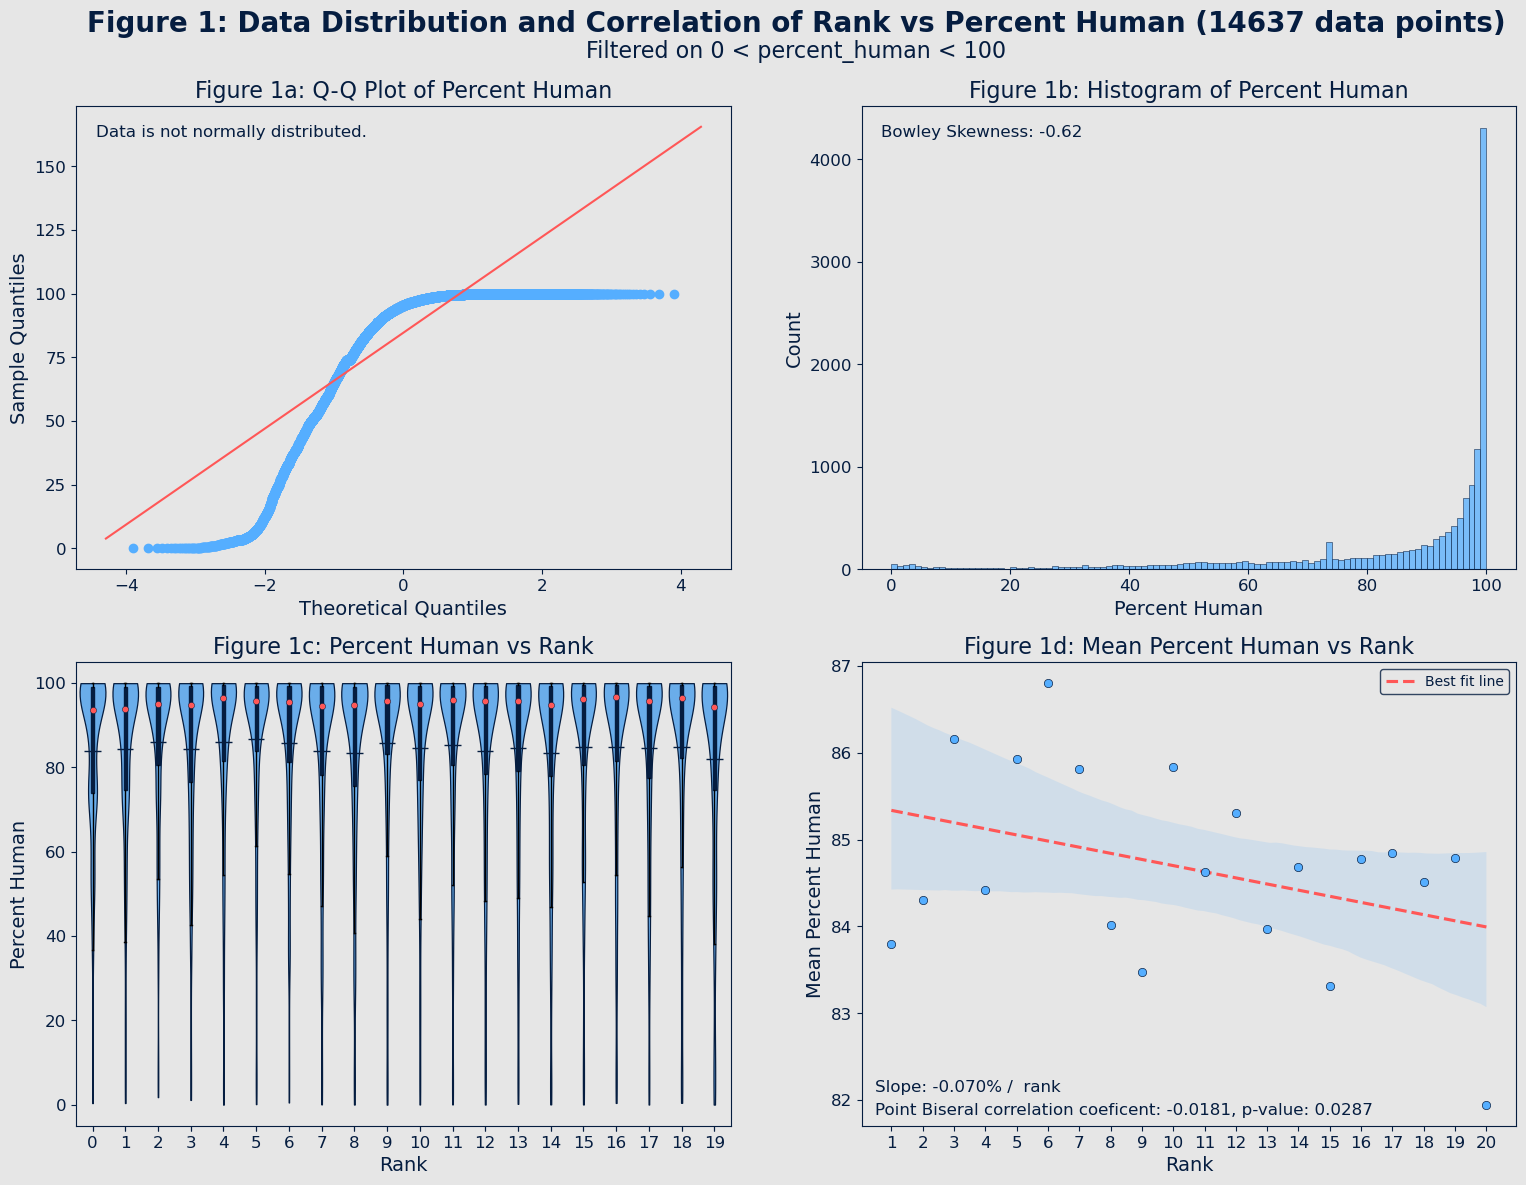

In [37]:
multiplotv_dark_f(df, 'Figure 1', 'percent_human', 0, 100, dark_mode=False)

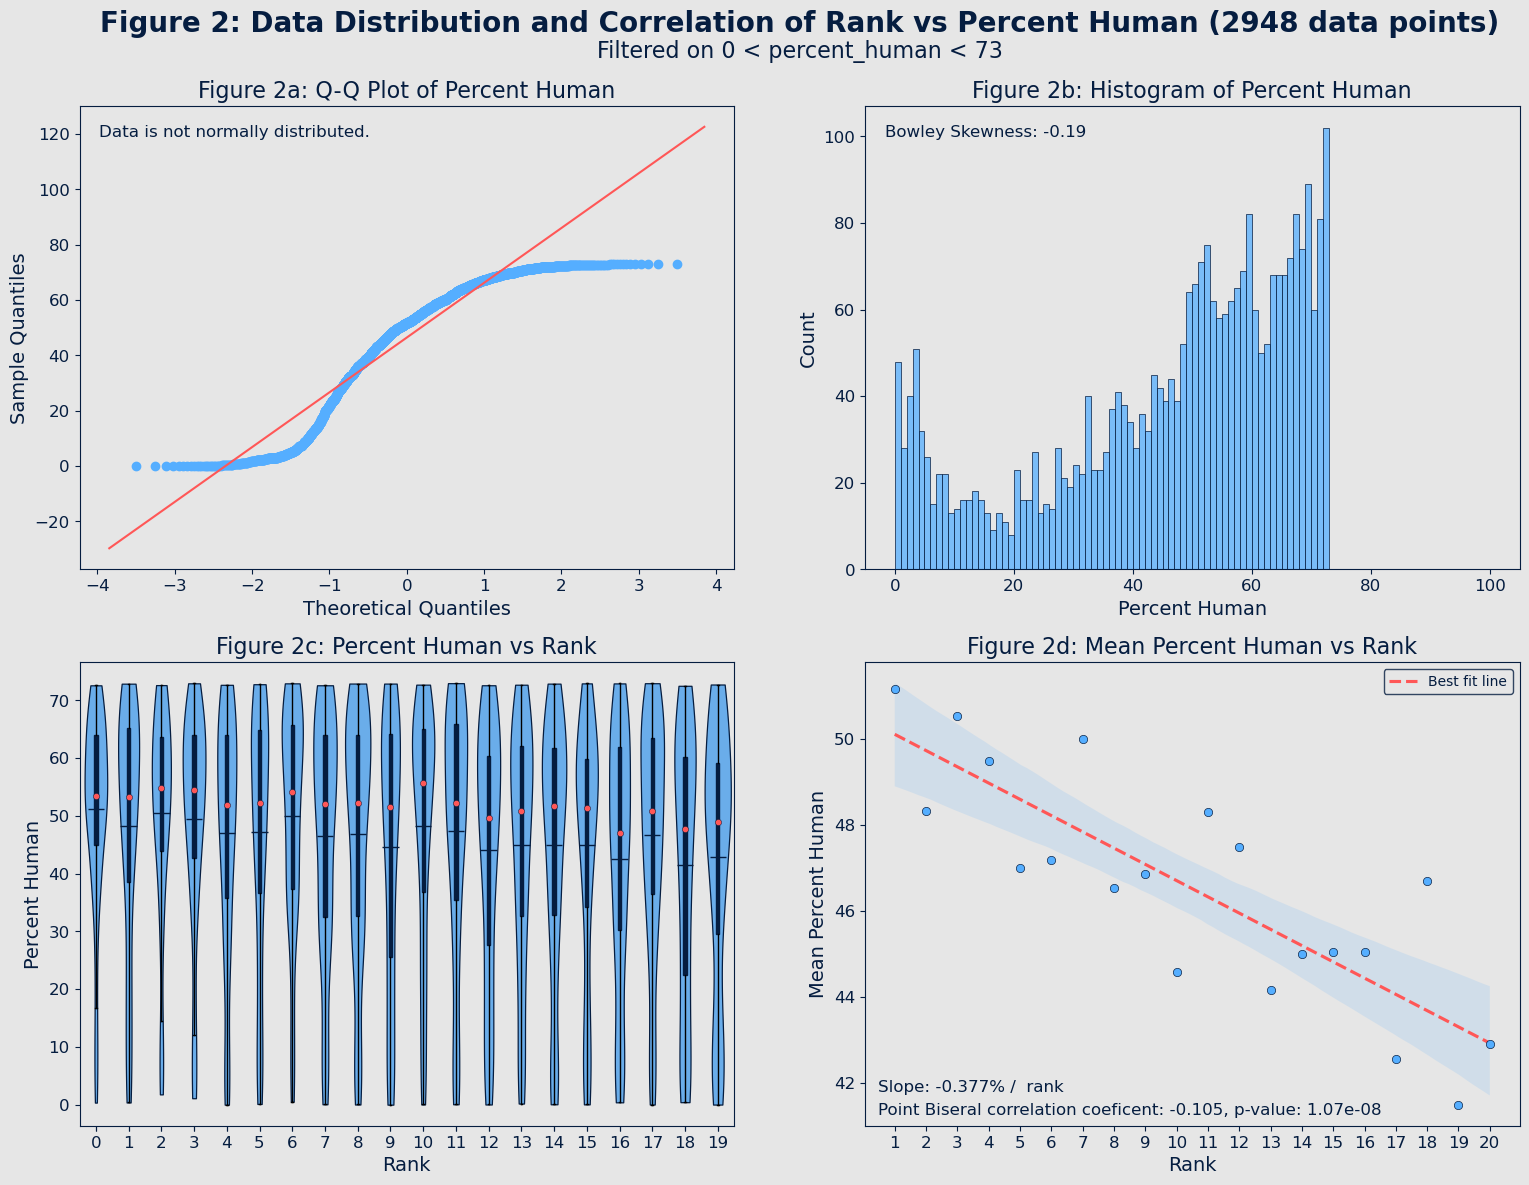

In [38]:
multiplotv_dark_f(df, 'Figure 2','percent_human', 0, 73, dark_mode=False)

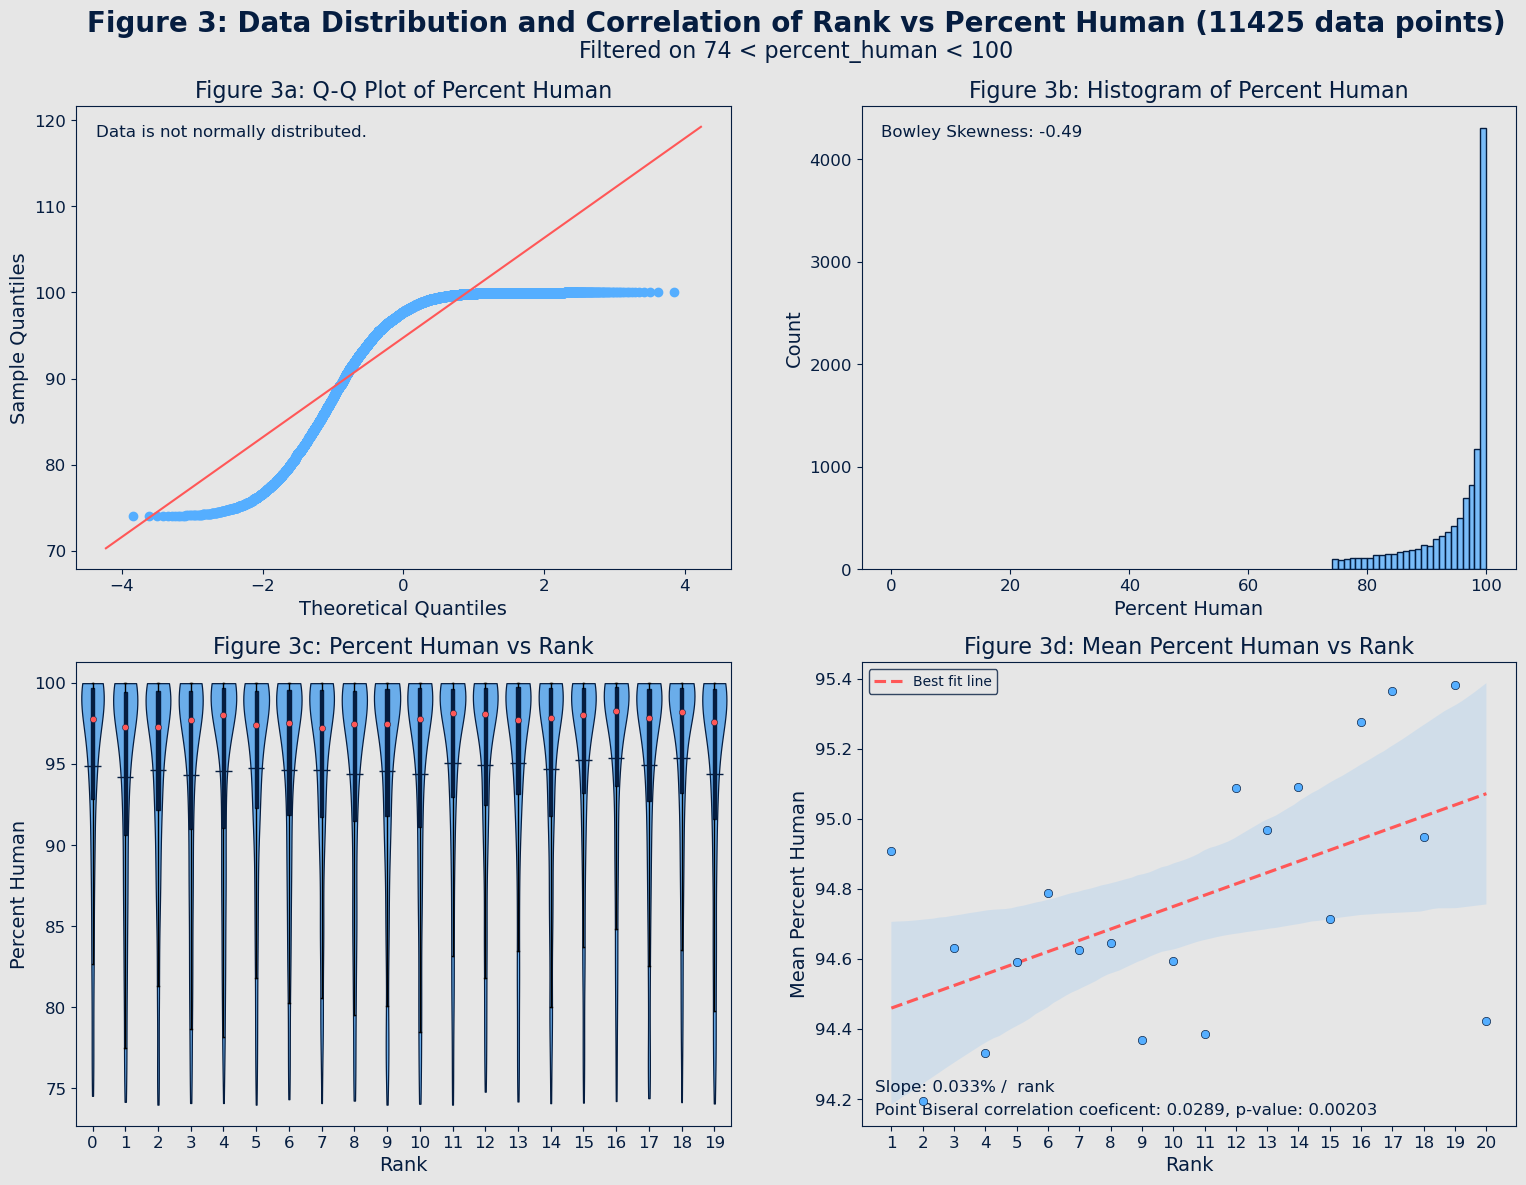

In [39]:
multiplotv_dark_f(df, 'Figure 3','percent_human', 74, 100, dark_mode=False)

In [40]:
# try cube roots